In [3]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [4]:
df0 = pd.read_csv("restructured_fundamental_data/compiled_balance_sheet_data.csv")
df1 = pd.read_csv("restructured_fundamental_data/compiled_cash_flow_data.csv")
df2 = pd.read_csv("restructured_fundamental_data/compiled_income_statement_data.csv")
df_target = pd.read_csv("Intraday_Data_Matthew/Restructured_Intraday_Data.csv").iloc[:,1:]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# stock_grouped = 
# df_y = df_target.groupby(['ticker']).get_group('AAPL').iloc[:,3]
df0 = df0.iloc[:,1:]
df1 = df1.iloc[:,4:]
df2 = df2.iloc[:,4:]
df_X = pd.concat([df0,df1, df2], axis=1)
df_X

,ticker,time,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
0,AAPL,2021-09-21T16:00:00Z,USD,3.298400e+11,0.0,0.0,1.364100e+10,2.655600e+11,6.428000e+10,0.0,...,0.0,2.625000e+09,8.143400e+10,1.112900e+10,4.617900e+10,243000000.0,0.0,2.174400e+10,2.174400e+10,0.0
1,AAPL,2021-09-21T15:00:00Z,USD,3.298400e+11,0.0,0.0,1.364100e+10,2.655600e+11,6.428000e+10,0.0,...,0.0,2.625000e+09,8.143400e+10,1.112900e+10,4.617900e+10,243000000.0,0.0,2.174400e+10,2.174400e+10,0.0
2,AAPL,2021-09-21T14:00:00Z,USD,3.298400e+11,0.0,0.0,1.364100e+10,2.655600e+11,6.428000e+10,0.0,...,0.0,2.625000e+09,8.143400e+10,1.112900e+10,4.617900e+10,243000000.0,0.0,2.174400e+10,2.174400e+10,0.0
3,AAPL,2021-09-21T13:00:00Z,USD,3.298400e+11,0.0,0.0,1.364100e+10,2.655600e+11,6.428000e+10,0.0,...,0.0,2.625000e+09,8.143400e+10,1.112900e+10,4.617900e+10,243000000.0,0.0,2.174400e+10,2.174400e+10,0.0
4,AAPL,2021-09-21T12:00:00Z,USD,3.298400e+11,0.0,0.0,1.364100e+10,2.655600e+11,6.428000e+10,0.0,...,0.0,2.625000e+09,8.143400e+10,1.112900e+10,4.617900e+10,243000000.0,0.0,2.174400e+10,2.174400e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579228,ZTS,2013-02-01T14:00:00Z,USD,6.262000e+09,868000000.0,0.0,3.020000e+08,2.221000e+09,4.026000e+09,0.0,...,0.0,8.400000e+07,1.176000e+09,5.900000e+08,4.330000e+08,-79000000.0,0.0,0.000000e+00,2.740000e+08,0.0
3579229,ZTS,2013-02-01T13:00:00Z,USD,6.262000e+09,868000000.0,0.0,3.020000e+08,2.221000e+09,4.026000e+09,0.0,...,0.0,8.400000e+07,1.176000e+09,5.900000e+08,4.330000e+08,-79000000.0,0.0,0.000000e+00,2.740000e+08,0.0
3579230,ZTS,2013-02-01T12:00:00Z,USD,6.262000e+09,868000000.0,0.0,3.020000e+08,2.221000e+09,4.026000e+09,0.0,...,0.0,8.400000e+07,1.176000e+09,5.900000e+08,4.330000e+08,-79000000.0,0.0,0.000000e+00,2.740000e+08,0.0
3579231,ZTS,2013-02-01T11:00:00Z,USD,6.262000e+09,868000000.0,0.0,3.020000e+08,2.221000e+09,4.026000e+09,0.0,...,0.0,8.400000e+07,1.176000e+09,5.900000e+08,4.330000e+08,-79000000.0,0.0,0.000000e+00,2.740000e+08,0.0


In [23]:

subs = 'Earning'
 
res = [i for i in list(df_X.columns) if subs in i]
res

['retainedEarnings', 'retainedEarningsTotalEquity']

In [24]:
import random
ticker_names = list(df_X.ticker.unique())
ticker_names = [x for x in ticker_names if x == x]
l_ticker = random.sample(ticker_names, 5)
l_ticker

['WFC', 'QCOM', 'UNH', 'GOOGL', 'PFE']

In [74]:
df_y = pd.DataFrame()
X = pd.DataFrame()
for i in (l_ticker):
    print(i)
    left = df_target.groupby(['ticker']).get_group(i).sort_values('time').iloc[:,:2]
    right = df_target.groupby(['ticker']).get_group(i).sort_values('time').iloc[:,2:].pct_change()
    df_y = df_y.append(pd.concat([left,right], axis=1).dropna().reset_index(drop=True))
    print('y appended')
    X = X.append(df_X.groupby(['ticker']).get_group(i).sort_values('time').reset_index(drop=True).iloc[1:,:])
    print('x appended')
df_y

MA
y appended
x appended
KO
y appended
x appended
BAC
y appended
x appended
SPGI
y appended
x appended
TJX
y appended
x appended


,time,ticker,open,close,high,low,volume
0,2006-05-25T11:00:00Z,MA,0.095530,-0.010202,0.019189,0.077087,-0.721161
1,2006-05-25T12:00:00Z,MA,-0.010202,0.003190,-0.024071,-0.004458,-0.631086
2,2006-05-25T13:00:00Z,MA,0.003190,0.006360,0.005372,0.006716,-0.127169
3,2006-05-25T14:00:00Z,MA,0.007094,0.011667,0.015545,0.014579,0.201998
4,2006-05-25T15:00:00Z,MA,0.011173,0.030754,0.027027,0.012908,0.580760
...,...,...,...,...,...,...,...
29172,2020-09-29T12:00:00Z,TJX,-0.006368,0.005287,-0.001114,0.001591,-0.165557
29173,2020-09-29T13:00:00Z,TJX,0.005400,0.011672,0.011950,0.004187,0.142323
29174,2020-09-29T14:00:00Z,TJX,0.011745,-0.003840,0.003747,0.008711,0.344988
29175,2020-09-29T15:00:00Z,TJX,-0.003839,-0.005145,-0.006550,-0.005148,0.613067


In [75]:

# X = pd.concat([df0.iloc[:,1:-1],df1.iloc[:,3:-1], df2.iloc[:,3:-1]], axis=1)
y = df_y.loc[:,'close']
y = y*100
y = y.dropna()
y

0       -1.020160
1        0.319018
2        0.636008
3        1.166748
4        3.075444
           ...   
29172    0.528745
29173    1.167156
29174   -0.383951
29175   -0.514523
29176    0.018537
Name: close, Length: 135489, dtype: float64

In [76]:
# y = df_y
X = X.loc[:,~X.columns.duplicated()].iloc[:,3:].dropna()
X

,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,capitalStock,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
1,3.710961e+09,270558000.0,0.0,614620000.0,2.398634e+09,1.307707e+09,0.0,1.244964e+09,1.000000e+06,0.0,...,0.0,66173000.0,7.384530e+08,5.557400e+08,5.305200e+08,10204000.0,0.0,0.0,126744000.0,0.0
2,3.710961e+09,270558000.0,0.0,614620000.0,2.398634e+09,1.307707e+09,0.0,1.244964e+09,1.000000e+06,0.0,...,0.0,66173000.0,7.384530e+08,5.557400e+08,5.305200e+08,10204000.0,0.0,0.0,126744000.0,0.0
3,3.710961e+09,270558000.0,0.0,614620000.0,2.398634e+09,1.307707e+09,0.0,1.244964e+09,1.000000e+06,0.0,...,0.0,66173000.0,7.384530e+08,5.557400e+08,5.305200e+08,10204000.0,0.0,0.0,126744000.0,0.0
4,3.710961e+09,270558000.0,0.0,614620000.0,2.398634e+09,1.307707e+09,0.0,1.244964e+09,1.000000e+06,0.0,...,0.0,66173000.0,7.384530e+08,5.557400e+08,5.305200e+08,10204000.0,0.0,0.0,126744000.0,0.0
5,3.710961e+09,270558000.0,0.0,614620000.0,2.398634e+09,1.307707e+09,0.0,1.244964e+09,1.000000e+06,0.0,...,0.0,66173000.0,7.384530e+08,5.557400e+08,5.305200e+08,10204000.0,0.0,0.0,126744000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29173,2.656840e+10,0.0,0.0,425027000.0,2.190783e+10,5.566756e+09,78007000.0,1.650154e+09,1.200631e+09,0.0,...,0.0,122201000.0,6.667575e+09,1.527768e+09,5.174490e+09,0.0,0.0,866656000.0,866656000.0,0.0
29174,2.656840e+10,0.0,0.0,425027000.0,2.190783e+10,5.566756e+09,78007000.0,1.650154e+09,1.200631e+09,0.0,...,0.0,122201000.0,6.667575e+09,1.527768e+09,5.174490e+09,0.0,0.0,866656000.0,866656000.0,0.0
29175,2.656840e+10,0.0,0.0,425027000.0,2.190783e+10,5.566756e+09,78007000.0,1.650154e+09,1.200631e+09,0.0,...,0.0,122201000.0,6.667575e+09,1.527768e+09,5.174490e+09,0.0,0.0,866656000.0,866656000.0,0.0
29176,2.656840e+10,0.0,0.0,425027000.0,2.190783e+10,5.566756e+09,78007000.0,1.650154e+09,1.200631e+09,0.0,...,0.0,122201000.0,6.667575e+09,1.527768e+09,5.174490e+09,0.0,0.0,866656000.0,866656000.0,0.0


**XGBOOST**

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
from sklearn.metrics import mean_squared_error

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

mse = mean_squared_error(y_test, preds)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % mse**(0.5))

[03:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 212.49
RMSE: 14.58


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


[03:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


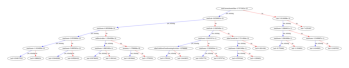

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

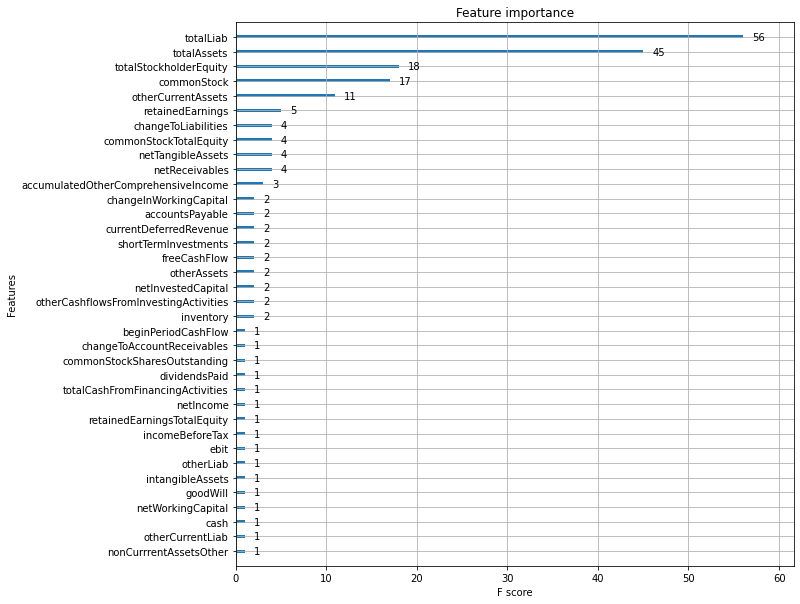

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig('xgb_factor_selection_result.jpg', format='jpg', dpi = 1200)
plt.show()

**ExtraTreesRegressor**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100,max_depth= 5, random_state=123).fit(X_train,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

preds = reg.predict(X_test)

mse = mean_squared_error(y_test, preds)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % mse**(0.5))

MSE: 7.02
RMSE: 2.65


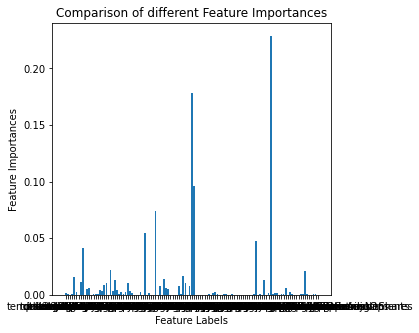

In [ ]:
feature_importance = reg.feature_importances_
# Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [ ]:
feature_importance

array([1.26849734e-03, 4.28259294e-04, 0.00000000e+00, 5.24305066e-04,
       1.60160245e-02, 2.43410685e-03, 9.54433997e-05, 1.10171861e-02,
       4.17156742e-02, 1.40565810e-04, 4.93901491e-03, 5.82848500e-03,
       2.24590084e-05, 4.61685144e-04, 8.33763208e-04, 3.45048336e-04,
       4.44680892e-03, 3.13766851e-03, 8.73712071e-03, 1.06100537e-02,
       1.45569931e-04, 2.16150255e-02, 3.09240728e-03, 1.27434536e-02,
       3.96394338e-03, 8.74869983e-04, 2.65191383e-03, 5.32318103e-04,
       2.31823208e-03, 1.00231902e-02, 3.08448504e-03, 1.48019249e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67233804e-03,
       0.00000000e+00, 5.42486310e-02, 0.00000000e+00, 1.25540228e-03,
       0.00000000e+00, 0.00000000e+00, 7.43287286e-02, 0.00000000e+00,
       7.84320393e-03, 0.00000000e+00, 1.39037539e-02, 5.66284319e-03,
       5.34813783e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.13190518e-03, 9.33666056e-04, 1.70044159e-02,
      

In [ ]:
np.argwhere(feature_importance > 0.05).flatten().tolist()

[37, 42, 59, 60, 96]

In [ ]:
X.iloc[:, np.argwhere(feature_importance > 0.05).flatten().tolist()]

,commonStockTotalEquity,nonCurrrentAssetsOther,netInvestedCapital,commonStockSharesOutstanding,reconciledDepreciation
0,5.498900e+10,4.485400e+10,1.860710e+11,1.678174e+10,2.832000e+09
1,5.498900e+10,4.485400e+10,1.860710e+11,1.678174e+10,2.832000e+09
2,5.498900e+10,4.485400e+10,1.860710e+11,1.678174e+10,2.832000e+09
3,5.498900e+10,4.485400e+10,1.860710e+11,1.678174e+10,2.832000e+09
4,5.498900e+10,4.485400e+10,1.860710e+11,1.678174e+10,2.832000e+09
...,...,...,...,...,...
31183,1.960000e+09,9.400000e+07,0.000000e+00,2.084925e+10,0.000000e+00
31184,1.960000e+09,9.400000e+07,0.000000e+00,2.084925e+10,0.000000e+00
31185,1.960000e+09,9.400000e+07,0.000000e+00,2.084925e+10,0.000000e+00
31186,1.960000e+09,9.400000e+07,0.000000e+00,2.084925e+10,0.000000e+00


In [78]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

params = {
    'max_depth': hp.quniform('max_depth', 5, 9, 1),
    'gamma': hp.uniform('gamma', 0, 4),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
    'subsample' : hp.uniform('subsample', 0.25, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 1.5, 2.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'seed': 0
}
best_model = None
best_r2 = -np.inf

def objective(space):
    global best_model
    global best_r2
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        min_child_weight=int(space['min_child_weight']),
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        reg_lambda=space['reg_lambda'],
        reg_alpha=space['reg_alpha']
    )
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=10, verbose=False)
    rmse_scores = -cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error', n_jobs=-1)
    r2_scores = cross_val_score(model, X_test, y_test, scoring='r2', n_jobs=-1)

    if np.mean(r2_scores) > best_r2:
        best_model = model
        best_r2 = np.mean(r2_scores)

    print (f"r2: {np.mean(r2_scores)} -- rmse: {np.mean(rmse_scores)}")
    return {'loss': np.mean(rmse_scores), 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



r2: -0.013900926146337112 -- rmse: 0.7509439041406117  
r2: -0.01375610860509786 -- rmse: 0.7509103353763159                             
r2: -0.0076642754317087555 -- rmse: 0.7486288486992255                             
r2: -0.00580091155337521 -- rmse: 0.7479352681422549                               
r2: -0.010839528457520852 -- rmse: 0.7498052131996629                              
r2: -0.013617029414179083 -- rmse: 0.7508454387055508                              
r2: -0.013808641093631512 -- rmse: 0.7509429380889501                              
r2: -0.021690552372174786 -- rmse: 0.7538550059240176                            
r2: -0.014688920944191386 -- rmse: 0.7512244245196704                            
r2: -0.01111231166167701 -- rmse: 0.7499280146687409                             
r2: -0.011961897196202198 -- rmse: 0.7502331308489423                             
r2: -0.015146321386787865 -- rmse: 0.7514131970034573                             
r2: -0.007375750886189092 -- r

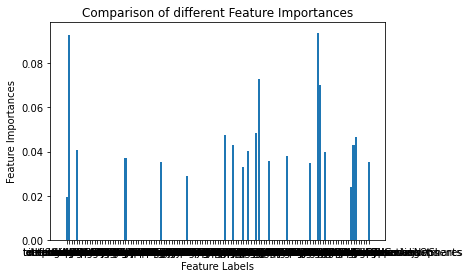

In [79]:
import matplotlib.pyplot as plt
feature_importance = best_model.feature_importances_
# Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

**Mock Factor Portfolio**

In [174]:
#Model feature output
f_list = ['totalAssets','totalLiab','totalStockholderEquity','commonStock', 'netDebt', 'nonCurrentAssetsTotal', 'netWorkingCapital', 'otherNonCashItems', 'grossProfit', 'intangibleAssets', 'changeToLiabilities', 
'otherCashflowsFromInvestingActivities', 'dividendsPaid','ebitda','depreciationAndAmortization', 'costOfRevenue']
# features = ['ticker','time'] + list(X.iloc[:, np.argwhere(feature_importance > 0.045).flatten().tolist()].columns)
features = ['ticker', 'time']

In [175]:
test = df_target.groupby(['ticker']).get_group('AAPL')
for x in range(len(f_list)):
    if x == 0:
        features.append(f_list[x])
    else:
        features[2] = f_list[x]
    print(f_list[x])
    print(features)
    temp = df_X.loc[:,features]
    temp.insert(loc=1,column='ntime',value=temp['time'].str[:7])
    temp['time']=temp['time'].str[:10]
    fdf = temp[temp['ntime'].isin(temp.groupby(['ticker']).get_group('AAPL').groupby(['ntime']).first().reset_index().iloc[::3, :].reset_index(drop=True)['ntime'])].reset_index(drop=True).groupby(['ticker','ntime']).first().reset_index()
    fdf.insert(loc=0, column='group', value=fdf.time.factorize()[0])
    dfs = dict(tuple(fdf.groupby(['group'])))
    time = []
    long = []
    short = []
    for i in range(71):
        normalized_df=(dfs[i].iloc[:,3:]-dfs[i].iloc[:,3:].mean())/dfs[i].iloc[:,3:].std()
        dfs[i]['sum'] = normalized_df.sum(axis=1)
        time.append(dfs[i].iloc[0,2])
        long.append(list(dfs[i].sort_values(by = 'sum', ascending = False).iloc[0:5,1]))
        short.append(list(dfs[i].sort_values(by = 'sum', ascending = False).iloc[-5:,1]))
        output = pd.DataFrame(list(zip(time,long,short)),columns =['time','long','short']).iloc[:-3]
    ret_long = [0]
    ret_long_total = [0]
    ret_short = [0]
    ret_short_total = [0]
    for i in range(len(output)-2):
        start = output.iloc[i+1,0]
        if int(output.iloc[i+2,0][-2:]) == 1:
            end = str(int(output.iloc[i+2,0][:4])-1)+'-12'
        elif int(output.iloc[i+2,0][-2:]) == 10:
            end = output.iloc[i+2,0][:-2]+'09'
        else:
            end = output.iloc[i+2,0][:-1]+str(int(output.iloc[i+2,0][-1])-1)
        
        ret_long.append([])
        ret_short.append([])
        l_total = 0
        r_total = 0
        print(start,end)
        for j in range(len(output.iloc[i,1])):
            ticker = output.iloc[i,1][j]
            position = 'long'
            calc = return_calc(ticker,start,end,position)
            ret_long[i+1].append(calc)
            l_total += calc
        for j in range(len(output.iloc[i,2])):
            ticker = output.iloc[i,2][j]
            position = 'short'
            calc = return_calc(ticker,start,end,position)
            ret_short[i+1].append(calc)
            r_total += calc
        ret_long_total.append(l_total)
        ret_short_total.append(r_total)
    foutput = output[:-1]
    foutput['ret_long'] = ret_long
    foutput['ret_long_total'] = ret_long_total
    foutput['ret_short'] = ret_short
    foutput['ret_short_total'] = ret_short_total
    foutput.to_csv('mock_factor_portfolio/'+f_list[x]+'.csv')  
    print('Done with '+f_list[x])

commonStock
['ticker', 'time', 'commonStock']
2004-04 2004-06


<ipython-input-171-947b24a0dd76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ntime'] = test['time'].str[:10]


2004-07 2004-09
2004-10 2004-12
2005-01 2005-03
2005-04 2005-06
2005-07 2005-09
2005-10 2005-12
2006-01 2006-03
2006-04 2006-06
2006-07 2006-09
2006-10 2006-12
2007-01 2007-03
2007-04 2007-06
2007-07 2007-09
2007-10 2007-12
2008-01 2008-03
2008-04 2008-06
2008-07 2008-09
2008-10 2008-12
2009-01 2009-03
2009-04 2009-06
2009-07 2009-09
2009-10 2009-12
2010-01 2010-03
2010-04 2010-06
2010-07 2010-09
2010-10 2010-12
2011-01 2011-03
2011-04 2011-06
2011-07 2011-09
2011-10 2011-12
2012-01 2012-03
2012-04 2012-06
2012-07 2012-09
2012-10 2012-12
2013-01 2013-03
2013-04 2013-06
2013-07 2013-09
2013-10 2013-12
2014-01 2014-03
2014-04 2014-06
2014-07 2014-09
2014-10 2014-12
2015-01 2015-03
2015-04 2015-06
2015-07 2015-09
2015-10 2015-12
2016-01 2016-03
2016-04 2016-06
2016-07 2016-09
2016-10 2016-12
2017-01 2017-03
2017-04 2017-06
2017-07 2017-09
2017-10 2017-12
2018-01 2018-03
2018-04 2018-06
2018-07 2018-09
2018-10 2018-12
2019-01 2019-03
2019-04 2019-06
2019-07 2019-09
2019-10 2019-12
2020-01 

<ipython-input-175-a34946e8f6aa>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foutput['ret_long'] = ret_long
<ipython-input-175-a34946e8f6aa>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foutput['ret_long_total'] = ret_long_total
<ipython-input-175-a34946e8f6aa>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Done with commonStock
netDebt
['ticker', 'time', 'netDebt']
2004-04 2004-06
2004-07 2004-09
2004-10 2004-12
2005-01 2005-03
2005-04 2005-06
2005-07 2005-09
2005-10 2005-12
2006-01 2006-03
2006-04 2006-06
2006-07 2006-09
2006-10 2006-12
2007-01 2007-03
2007-04 2007-06
2007-07 2007-09
2007-10 2007-12
2008-01 2008-03
2008-04 2008-06
2008-07 2008-09
2008-10 2008-12
2009-01 2009-03
2009-04 2009-06
2009-07 2009-09
2009-10 2009-12
2010-01 2010-03
2010-04 2010-06
2010-07 2010-09
2010-10 2010-12
2011-01 2011-03
2011-04 2011-06
2011-07 2011-09
2011-10 2011-12
2012-01 2012-03
2012-04 2012-06
2012-07 2012-09
2012-10 2012-12
2013-01 2013-03
2013-04 2013-06
2013-07 2013-09
2013-10 2013-12
2014-01 2014-03
2014-04 2014-06
2014-07 2014-09
2014-10 2014-12
2015-01 2015-03
2015-04 2015-06
2015-07 2015-09
2015-10 2015-12
2016-01 2016-03
2016-04 2016-06
2016-07 2016-09
2016-10 2016-12
2017-01 2017-03
2017-04 2017-06
2017-07 2017-09
2017-10 2017-12
2018-01 2018-03
2018-04 2018-06
2018-07 2018-09
2018-10 2018

In [172]:
t_list = ['GOOG', 'GOOGL', 'AAPL', 'MSFT', 'XOM']
for i in t_list:
    print(i)
    total = return_calc(i,'2008-10','2008-12','long')

print(total)

GOOG


<ipython-input-171-947b24a0dd76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ntime'] = test['time'].str[:10]


GOOGL
AAPL
MSFT
XOM
-2.112000000000002


In [170]:
# test[test['ntime'].str.contains('2008-12')].sort_values(by='ntime', ascending=False).iloc[0,-1]
test = df_target.groupby(['ticker']).get_group('GOOGL')
test['ntime'] = test['time'].str[:10]
test[test['ntime'].str.contains('2008-11')].sort_values(by='ntime', ascending=False).iloc[0,-1]
# test

<ipython-input-170-095b52fa521d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ntime'] = test['time'].str[:10]


'2008-11-28'

**Return Calculation**




In [171]:
def return_calc(ticker,start,end,position):
  test = df_target.groupby(['ticker']).get_group(ticker)
  test['ntime'] = test['time'].str[:10]
  if ticker == 'GOOGL' and end == '2008-12':
    end = '2008-11'
  n_start = test[test['ntime'].str.contains(start)].sort_values(by='ntime').iloc[0,-1]
  n_end = test[test['ntime'].str.contains(end)].sort_values(by='ntime', ascending=False).iloc[0,-1]
  buy = test.groupby(['ntime']).get_group(n_start).sort_values(by='time').loc[:,'open'].reset_index(drop=True)[0]
  sell = test.groupby(['ntime']).get_group(n_end).sort_values(by='time',ascending=False).loc[:,'close'].reset_index(drop=True)[0]
  if position == 'long':
    return buy-sell
  if position == 'short':
    return -1*(buy-sell)
  return 0

In [90]:
ret_long = [0]
ret_long_total = [0]
ret_short = [0]
ret_short_total = [0]
for i in range(len(output)-2):
  start = output.iloc[i+1,0]
  if int(output.iloc[i+2,0][-2:]) == 1:
    end = str(int(output.iloc[i+2,0][:4])-1)+'-12'
  elif int(output.iloc[i+2,0][-2:]) == 10:
    end = output.iloc[i+2,0][:-2]+'09'
  else:
    end = output.iloc[i+2,0][:-1]+str(int(output.iloc[i+2,0][-1])-1)
  
  ret_long.append([])
  ret_short.append([])
  l_total = 0
  r_total = 0
  print(start,end)
  for j in range(len(output.iloc[i,1])):
    ticker = output.iloc[i,1][j]
    position = 'long'
    ret_long[i+1].append(return_calc(ticker,start,end,position))
    l_total += return_calc(ticker,start,end,position)
  for j in range(len(output.iloc[i,2])):
    ticker = output.iloc[i,2][j]
    position = 'short'
    ret_short[i+1].append(return_calc(ticker,start,end,position))
    r_total += return_calc(ticker,start,end,position)
  ret_long_total.append(l_total)
  ret_short_total.append(r_total)


2004-04 2004-06


<ipython-input-89-ef8ed01c799a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ntime'] = test['time'].str[:10]


2004-07 2004-09
2004-10 2004-12
2005-01 2005-03
2005-04 2005-06
2005-07 2005-09
2005-10 2005-12
2006-01 2006-03
2006-04 2006-06
2006-07 2006-09
2006-10 2006-12
2007-01 2007-03
2007-04 2007-06
2007-07 2007-09
2007-10 2007-12
2008-01 2008-03
2008-04 2008-06
2008-07 2008-09
2008-10 2008-12
2009-01 2009-03
2009-04 2009-06
2009-07 2009-09
2009-10 2009-12
2010-01 2010-03
2010-04 2010-06
2010-07 2010-09
2010-10 2010-12
2011-01 2011-03
2011-04 2011-06
2011-07 2011-09
2011-10 2011-12
2012-01 2012-03
2012-04 2012-06
2012-07 2012-09
2012-10 2012-12
2013-01 2013-03
2013-04 2013-06
2013-07 2013-09
2013-10 2013-12
2014-01 2014-03
2014-04 2014-06
2014-07 2014-09
2014-10 2014-12
2015-01 2015-03
2015-04 2015-06
2015-07 2015-09
2015-10 2015-12
2016-01 2016-03
2016-04 2016-06
2016-07 2016-09
2016-10 2016-12
2017-01 2017-03
2017-04 2017-06
2017-07 2017-09
2017-10 2017-12
2018-01 2018-03
2018-04 2018-06
2018-07 2018-09
2018-10 2018-12
2019-01 2019-03
2019-04 2019-06
2019-07 2019-09
2019-10 2019-12
2020-01 

In [91]:
foutput = output[:-1]
foutput['ret_long'] = ret_long
foutput['ret_long_total'] = ret_long_total
foutput['ret_short'] = ret_short
foutput['ret_short_total'] = ret_short_total
foutput

<ipython-input-91-96590592e4e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foutput['ret_long'] = ret_long
<ipython-input-91-96590592e4e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foutput['ret_long_total'] = ret_long_total
<ipython-input-91-96590592e4e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,time,long,short,ret_long,ret_long_total,ret_short,ret_short_total
0,2004-01,"[GE, WMT, XOM, VZ, PFE]","[NFLX, VRTX, EQIX, LRCX, REGN]",0,0.000,0,0.000
1,2004-04,"[GE, XOM, VZ, WMT, CVX]","[NFLX, LRCX, REGN, EQIX, VRTX]","[-1.277000000000001, 3.956000000000003, -1.759...",1.899,"[0.19700000000000006, 1.379999999999999, -1.23...",-1.633
2,2004-07,"[GE, XOM, VZ, CVX, MSFT]","[EQIX, CRM, REGN, VRTX, DHR]","[-0.8640000000000008, -2.5219999999999985, -1....",-9.003,"[-2.898, -3.975999999999999, -1.85999999999999...",-11.502
3,2004-10,"[CVX, XOM, GE, VZ, JPM]","[LRCX, EQIX, CRM, VRTX, REGN]","[-1.7659999999999982, -1.8339999999999996, -0....",-4.803,"[9.751999999999999, 0.30299999999999994, 0.289...",12.630
4,2005-01,"[GE, XOM, VZ, WMT, CVX]","[BLK, EQIX, REGN, CRM, VRTX]","[-3.6930000000000014, -5.474999999999998, 0.29...",-3.855,"[0.07099999999999795, -0.19600000000000506, -0...",-5.954
...,...,...,...,...,...,...,...
62,2019-07,"[T, MSFT, VZ, XOM, WMT]","[AMD, INTU, NOW, REGN, MMC]","[-4.304000000000002, -4.028000000000006, -3.64...",-4.764,"[-39.129999999999995, -28.01000000000002, 38.2...",-29.315
63,2019-10,"[T, AAPL, VZ, WMT, XOM]","[SLB, REGN, AXP, BSX, FISV]","[-1.6550000000000011, -18.36700000000002, -1.8...",-22.783,"[16.44, -4.262999999999977, 28.769999999999982...",149.661
64,2020-01,"[T, AAPL, CVX, AMZN, MSFT]","[REGN, NOW, VRTX, JPM, C]","[8.463999999999995, 10.736999999999995, 6.4830...",61.171,"[-25.693999999999996, 113.72000000000003, -38....",15.720
65,2020-04,"[T, VZ, WMT, MSFT, AAPL]","[AMD, NOW, SLB, DHR, USB]","[-2.3560000000000016, -29.662, -19.467, -828.9...",-929.236,"[137.21999999999997, 134.26999999999998, 59.08...",351.674


In [190]:
sum_list = []
for i in os.listdir()[1:]:
    read = pd.read_csv(i)
    sum_list.append([i[:-4],sum(read['ret_long_total']),sum(read['ret_short_total'])])
sum_list

[['netWorkingCapital', -570.2769999999999, 573.991],
 ['intangibleAssets', -136.19800000000015, 1029.7849999999999],
 ['totalLiab', -88.00899999999984, 1994.1869999999997],
 ['ebitda', -1096.058, 857.3919999999999],
 ['dividendsPaid', -303.348, 2051.347000000001],
 ['otherNonCashItems', -266.984, 894.8320000000007],
 ['otherCashflowsFromInvestingActivities',
  -374.13999999999993,
  769.0360000000001],
 ['netDebt', -92.52299999999988, 3487.344000000001],
 ['grossProfit', -473.6300000000001, 923.1930000000001],
 ['totalAssets', -94.02699999999987, 2189.847],
 ['commonStock', -1073.1430000000003, 909.6080000000001],
 ['nonCurrentAssetsTotal', 23.20400000000011, 2173.1280000000006],
 ['costOfRevenue', -2347.697, 1347.352],
 ['totalStockholderEquity', -514.7350000000001, 726.7230000000004],
 ['depreciationAndAmortization', -2069.7170000000006, 344.691],
 ['changeToLiabilities', -1973.7960000000005, 1206.0920000000006]]

In [195]:
df_rank = pd.DataFrame(sum_list)
df_rank.columns = ["Feature", "Long", "Short"]
df_rank.sort_values('Long',ascending=False).reset_index(drop=True).to_csv('ranked_features.csv')


In [196]:
df_rank.sort_values('Long',ascending=False).reset_index(drop=True)

,Feature,Long,Short
0,nonCurrentAssetsTotal,23.204,2173.128
1,totalLiab,-88.009,1994.187
2,netDebt,-92.523,3487.344
3,totalAssets,-94.027,2189.847
4,intangibleAssets,-136.198,1029.785
5,otherNonCashItems,-266.984,894.832
6,dividendsPaid,-303.348,2051.347
7,otherCashflowsFromInvestingActivities,-374.140,769.036
8,grossProfit,-473.630,923.193
9,totalStockholderEquity,-514.735,726.723
